In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
# NCL stuff:
# are we an NCL or netCDF4 shop today?
try:
    import netCDF4
    def get_file(fname, mode='r'):
        return netCDF4.Dataset(fname, mode)
    print('** We are a netCDF4 shop today...')
except:
    #import Ngl, Nio
    import Nio
    def get_file(fname, mode='r'):
        return contextlib.closing(Nio.open_file(fname, mode))
    print('** We are a Nio shop today...')
#import pyncl
#
import pylab as plt
import numpy
#import scipy
#
import multiprocessing as mpp
import os,sys
import time
#import pathlib

import getpass
import subprocess
import contextlib

def file_report(fin):
    dims = fin.dimensions.values()
    dimnames = fin.dimensions.keys()
    #
    varnames_all = fin.variables.keys()
    varnames = [s for s in varnames_all if not s in dimnames]
    #
    print('** dims: ', list(zip(dimnames, dims)))
    #
    print('** varnames_all: ', varnames_all)
    print('** varnames: ', varnames)
    #

    print('type(fin.dimensions): ', type(fin.dimensions) )
    #
    return None


### Mount network resource (sshfs), if we are working locally
- This only if we want to pull down a (small) subset of data to our local machine
- use subprocess() to mount the remote FS
- Note we do * **not** * write our password in code, pull it from a (n unencrypted) data file, etc. In fact, in this script, we don't even write it to a variable
- If working on a tool server, etc. this drive will (probable) already be mounted.


In [3]:
#do_mount = True
do_mount = False
#
f_mount_out='/scratch'
f_mount_in='/data'
print('** fmount_out: {}'.format(f_mount_out))
print('** fmount_in: {}'.format(f_mount_in))
#
mazama_umount_data = 'umount {} && umount {}'.format(f_mount_in, f_mount_out)
#
#
if do_mount:
    f_mount_in = os.path.join(os.environ['HOME'], 'mazama_data')
    print('** fmount_in: {}'.format(f_mount_in))
    f_mount_out = os.path.join(os.environ['HOME'], 'mazama_scratch')
    print('** fmount_out: {}'.format(f_mount_out))



    #
    # this should work, in principle, but it is not (so far), and maybe for good reasons. I've definitely
    #. read taht using the -o password_stdin option sometimes does not work.
    #ssh_password = getpass.getpass('ssh password: ')
    #
    # sshfs cees-tool-7:/data ~/mazama_data -o password_stdin -o volname=mazama_data <<<
    #
    # set up sshfs call here...source
    mazama_mount_data_in = 'sshfs cees-tool-7:/data {} -o password_stdin -o volname=mazama_data <<< {}'
    mazama_mount_data_out = 'sshfs cees-tool-7:/scratch {} -o password_stdin -o volname=mazama_scratch <<< {}'
    #
    #
    #subprocess.call(mkdir_command, shell=True)
    subprocess.call(mazama_mount_data_in.format(f_mount_in, getpass.getpass()), shell=True)
    subprocess.call(mazama_mount_data_out.format(f_mount_out, getpass.getpass()), shell=True)
    #
    #del ssh_password
    #source
    print('ls f_mount: \n', os.listdir(f_mount))



** fmount_out: /scratch
** fmount_in: /data


In [4]:
# NOTE: probably need to connect (sshfs) to NFS (sshfs cees-tool-7:/data {f_mount})
input_file_path = 'ESS/regirock/cesm_archive/Rachel/U_V_T_Z3_plWACCMSC_CTL_122.cam.h2.0001-0202.nc'

input_file_path = os.path.join(f_mount_in, input_file_path)
#input_file_path = '/scratch/yoder/U_V_T_Z3_plWACCMSC_CTL_122.cam.h2.0001-0202.nc'
#
#output_file_path = 'my_output.nc'
#output_file_path = os.path.join(os.environ['HOME'], 'Codes/temp/my_output.nc')
output_file_path = os.path.join(f_mount_out, 'yoder/my_output.nc')
if not os.path.isdir(os.path.split(output_file_path)[0]):
    os.makedirs(os.path.split(output_file_path)[0])
#
#input_file_path = os.path.join(os.environ['HOME'], input_file_path)

#
print('** pth_name: {}'.format(input_file_path))
print('** output_pth: {}'.format(output_file_path))

#
#
# # we can also use pathlib to construct the path, but it does not really gain us much.
# #  nominally, we should construct the path from an orderd list of parts ['mazama_data', 'ESS', ...]
# #. and then .join() them, in the event that sommebody tries this from Windows. But for now,
# #. we'll let Windows usiers fix it themselves (if need be)...
#
# TODO: reorganize using a context manager. Nio.open_file() will not take a CM directly, but we 
#. can make one using contextlib:
# with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
#.  etc...
#.  etc...
# open the file; use a context handler:
# ... or maybe not. seems to not be compatible...
#
#fin = Nio.open_file(input_file_path, 'r')
#

** pth_name: /data/ESS/regirock/cesm_archive/Rachel/U_V_T_Z3_plWACCMSC_CTL_122.cam.h2.0001-0202.nc
** output_pth: /scratch/yoder/my_output.nc


### Data properties
- We've opend a data file handle...
- Now, let's look at some properties of the data set:
    - dimension and dimension names
    - Note that rank is the size of the dimensions array (dimensions of dimensions)
    - Note also the distinction between dimensions and variables. 
    - From a strict data-modeling standpoint, this is sort of silly, but it makes sense that it is the minimum (maximum?) level of slicing. After the dimensions, are attributes that group together... sort of.
   - And some additional diagnostics 
   

In [5]:
#with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
with get_file(input_file_path, 'r') as fin:
    file_report(fin)
    #
    print('##############')
    # note that the lat and lon variables are small (they are basically just indices):
    lats = fin.variables['lat']
    lons = fin.variables['lon']
    #p_levs = fin.variables['lev_p']
    p10 = fin.variables['lev_p'][2]
    #
    print('lats: ', [y for y in lats])
    print('lons: ', [x for x in lons])
    print('p10: ', p10)
    tm   = fin.variables['time']
    print('len(time): ', len(tm))
    #print('p_levs: ', [p for p in p_levs])

** dims:  [('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 73730
), ('lev_p', <class 'netCDF4._netCDF4.Dimension'>: name = 'lev_p', size = 13
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 96
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 144
)]
** varnames_all:  odict_keys(['U', 'time', 'lev_p', 'lat', 'lon', 'V', 'Z3', 'T', 'PV'])
** varnames:  ['U', 'V', 'Z3', 'T', 'PV']
type(fin.dimensions):  <class 'collections.OrderedDict'>
##############
lats:  [masked_array(data=-90.,
             mask=False,
       fill_value=1e+20), masked_array(data=-88.10526316,
             mask=False,
       fill_value=1e+20), masked_array(data=-86.21052632,
             mask=False,
       fill_value=1e+20), masked_array(data=-84.31578947,
             mask=False,
       fill_value=1e+20), masked_array(data=-82.42105263,
             mask=False,
       fill_value=1e+20), masked_array(data=-80.52631579,
             mask=False,


### Subsetting the raw data
- Open the raw/source data file (already done!)
- Take some 'slice' of our variable of interest

In [6]:
#with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
with get_file(input_file_path, 'r') as fin:
    # TODO: set up batching, and see if we can use a += syntax when we write to the output file.
    batch_size = 100
    udum = fin.variables['U'][0:batch_size, 2,:,:]
    # we can get a second (subsequent) slice like this:
    udum2 = fin.variables['U'][len(udum):len(udum)+batch_size, 2,:,:]
    #
    print('udum: ')
    print(len(udum))
    print('** ', udum.shape)
    #
    #
    print('udum2: ')
    print(len(udum2))
    print('** ', udum2.shape)
    #

udum: 
100
**  (100, 96, 144)
udum2: 
100
**  (100, 96, 144)


Any actual data in those sequences?


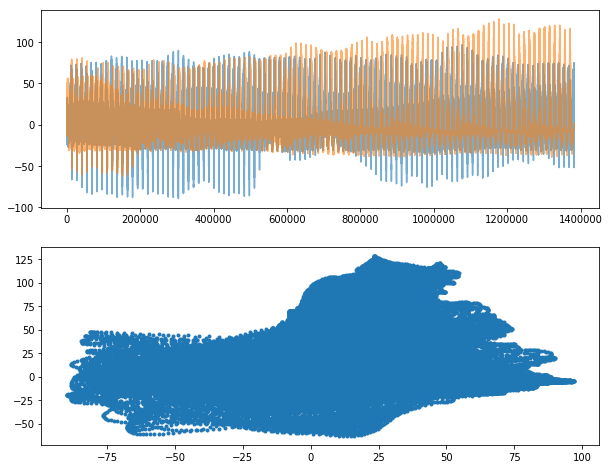

In [7]:
print('Any actual data in those sequences?')
#print('** ', udum[0:10])
#print('** ', udum2[0:10])
#
fg = plt.figure(figsize=(10,8))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
ax1.plot(numpy.ravel(udum), ls='-', marker='', alpha=.6)
ax1.plot(numpy.ravel(udum2), ls='-', marker='', alpha=.6)
#
ax2.plot(numpy.ravel(udum), numpy.ravel(udum2), marker='.', ls='')

### Export a subset of the data or a derived data set:
- Create a file for export
- Note that there are good and bad ways to do this (usually trading code complexity for speed)
- For optimal speed, we pre-define as much of the output as possible
- For simplicity, we might leave our principal dimension undefined -- or something like that.
- Note: we can open our file in modes; {'c': create,'r': read, {'w', 'r+', 'a', ???}: read+, append, write} 

#### What We are Going to Do:
- Create the output file
- Discuss in comments some file-writng methods, strategies, etc.
- Then do the file writing (exporting) in the following pane.


In [8]:
# create the file. define everything!
#
#
t0=time.time()
#
os.system('rm {}'.format(output_file_path))
# do we need to delete the file?
#with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
with get_file(input_file_path, 'r') as fin:
    # time dimension size:
    # we can get the full dimension size, if we are going to write the whole lot;
    # otherwise, maybe just a subset?
    print('*** ', fin.dimensions['time'])
    #n_time = fin.dimensions['time']
    n_time,n_lev, n_lat, n_lon = numpy.shape(fin.variables['U'])
    #
    # if we were batching, we might do something like this:
    # assume we'll take 10 iterations (or so)
    #n_batches = 10
    #n_time = n_batches*batch_size
    #
    print('** DEBUG: open output file...')
    #with contextlib.closing(Nio.open_file(output_file_path, 'c')) as fout:
    with get_file(output_file_path, 'w') as fout:
        #fout = Nio.open_file(output_file_path, 'c')
        fout.create_dimension('time', n_time)
        fout.create_dimension('lat', fin.dimensions['lat'])
        fout.create_dimension('lon', fin.dimensions['lon'])
        #
        # netCDF4 syntax:
        #fout.createDimension('time', n_time)
        #fout.createDimension('lat', n_lat)
        #fout.createDimension('lon', n_lon)
        
        print('** DEBUG: dimensions created: {}'.format(time.time()-t0))
        #
        # set the dimension variable values as well:
        # NOTE: this step may not be necessary; these variables might be brought along by
        #. the principal data, since those data have lat, lon, time listed as their dimensions.
        for v_name in ('lat', 'lon', 'time'):
            # netCDF4 syntax:
            #fout.createVariable(v_name, 'f', (v_name, ) )
            #fout.variables[v_name][:] = fin.variables[v_name][:]
            fout.create_variable(v_name, 'f', (v_name, ) )
            fout.variables[v_name][:] = fin.variables[v_name]
            #
            print('** DEBUG: var {} craeted'.format(v_name))
        print('** DEBUG: variables created (cumulative time): {}'.format(time.time()-t0))
        #
        fout.create_variable('U','f',('time','lat','lon'))
        #fout.createVariable('U','f',('time','lat','lon'))
        setattr(fout.variables['U'], 'standard_name', 'pressure')
        setattr(fout.variables['U'], 'units', 'kPa')
        print('** DEBUG: variagble[U] created (cum time): {}'.format(time.time()-t0))
        #
        # NOTE: the .set_value() syntax is required for scaler, non-indexed values (or so I have read).
        #. we can also use it for arrays, but only if we are assigning the whole value -- in other words, the 
        #. dimensinos must match. (this works if dim(udum)==dim(fout)). I assume the exception is if the output
        #. dimension is undefined.
        #
        #fout.variables['u'].assign_value(udum)        # this works if dimensions align
        #fout.variables['u'][0:len(udum)] = udum      # use this for partial assignment (note, i think this does allow 
        #                                            # (aka, will expand) for overflow -- [k,j] > len(fout.variable) )
        #
        # if this is going to take a long time, it might be smart to close and explicitly bufer.

        #
        # and we might want to close the file here:
        print('file created: {}'.format(time.time()-t0))
        print(file_report(fout))
        #fout.close()
    #
print('elapsed time to create the output file template: ', time.time()-t0)

***  <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 73730

** DEBUG: open output file...
** DEBUG: dimensions created: 93.36833643913269
** DEBUG: var lat craeted
** DEBUG: var lon craeted
** DEBUG: var time craeted
** DEBUG: variables created (cumulative time): 982.3418653011322
** DEBUG: variagble[U] created (cum time): 982.3423163890839
file created: 982.3423528671265
** dims:  [('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 73730
), ('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 96
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 144
)]
** varnames_all:  odict_keys(['lat', 'lon', 'time', 'U'])
** varnames:  ['U']
type(fin.dimensions):  <class 'collections.OrderedDict'>
None
elapsed time to create the output file template:  982.3452603816986


In [ ]:
# check our work. What have we written?
#with contextlib.closing(Nio.open_file(output_file_path, 'r')) as fin_check:
with get_file(output_file_pathk 'r') as fin_check:
    print('Some File Info: {}'.format(output_file_path))
    print(file_report(fin_check))
    #
    fin_check.close()

### Writing to the file
- Our basic operation is:
    - Read a batch of data from the source file (fin)
    - Do whatever we need to do to said data
    - Write something (in this case, just the data) to the output file
- We have soeme choices:
    - Buffer to a memory variable (aka, read into a local memory variable, then write that variable to output)
    - Internal buffers only (fout.variables[my_var_out][k:j] = fin.variables[my_var_in][l:m] )
        - For simple data transfers, this is probaby the best approach. In fact, we can probably skip batching, since the NetCDF objects are probably smart enough to manage memory.
    - Parallelization: 
        - Depending on where latency occurs, etc., there may be opportunity to speed this up via reading and writing in parallel channels. Basically, run separate threads over a set of index ranges.
        - Also, for simple filering or processing, the data transfer may be slow enough that it would make sense to parallelize the read/process steps (aka, extract a batch; submit to a processing thread, extract the next bit).


In [ ]:
t0 = time.time()
with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
    with contextlib.closing(Nio.open_file(output_file_path, 'a')) as fout:
        fout.variables['U'][:] = fin.variables['U'][:, 2,:,:]

#
print('elapsed time: ', time.time() - t0)

#### Batching:
- This is how to batch the write job
- But we will probably just let Nio figure out how to best do that
- ... except it turns out that Nio does a bad job of this, and it looks like we get a lot of benefit from batching/cacheing manually
- ...unless we decide to parallelize, in which case we'll do something similar to this
- ...but before we do that, we want to be sure that it will actually help.
- ... and so far, this (batched, SPP) is by far the fastest way to write the file.

In [ ]:
# First, demonstrate read/write with batches. It will be important to understand how to do this if we ever want
#. to do something more complicated that a straight transfer or simple filter.
# note: we don't need the same batch sizes:
batch_size_write = 2000
n_batches = int(numpy.ceil(n_time)/batch_size_write)
#
print('*** writing {} batches, of size {} (last batch might be smaller)'.format(n_batches, batch_size_write))

In [ ]:
#
# fib should already be open:
#fin = Nio.open_file(input_file_path, 'r')
#
t0 = time.time()
t1 = t0
t2 = t1
#
with contextlib.closing(Nio.open_file(input_file_path, 'r')) as fin:
    #
    with contextlib.closing(Nio.open_file(output_file_path, 'a')) as fout:
        # 'a', 'w', 'r+' all mean (read, write/append)
        #
        # extract data like: udum = fin.variables['U'][0:batch_size, 2,:,:]
        for j,k in enumerate(range(0, n_time, batch_size_write)):
            #print('** ** [{}:{}]'.format(k, k+batch_size_write))
            #
            # remember, our read-data are like:
            # udum = fin.variables['U'][0:batch_size, 2,:,:]
            # and we're making out output file more or less a mirror of that:
            # note: we never explicilty store the data in a local variable; the memory footprint
            #. is determined entirely by the NetCDF class, so really we can probably do this in one batch...
            #  unless we want to parallelize, in which case we can run each of thsed batches an a Process() thread,
            # in a Queue(), Pool(), etc.
            t1=t2
            t2 = time.time()
            k1 = min(k+batch_size_write, n_time)
            #
            print('begin k={}/{} batches [{}:{}]/{} :: {}.'.format(j, n_batches, k, k1, n_time, t2-t1))
            #
            #print('*** k:k1: {}:{}'.format(k,k1))
            fout.variables['U'][k:k1] = fin.variables['U'][k:k1, 2,:,:]
        #
        tt = time.time()
        print('total time: {}'.format(t2-t0) )


### Reading, writing in parallel:
- Note that we should not expect to see any improvement on this if the NetCDF backend(s) do not support parallel IO, but it's worth a try.
- But note that batching gives a 5-10 fold performance boost, so parallelization is probably worth a shot.
- The problem appears to be that we cannot pickle the Nio object. There may be some other way to do this. NetCDF has some parallel file options. 
- Maybe we should be using a different library (netcdf)? Note that ncl (and presumably Nio) can access multiple file formats, so we might be using (from Nio) a simple, low performance file handler that is capable of handling multiple file formats, but does nothing special with the NetCDF format.

In [ ]:
# ... ok, so this will be more difficult because we can't pickle the Nio object...
#
t0 = time.time()
n_cpu=4
P = mpp.Pool(n_cpu)
#
# we don't actually need to return anything from the chile processes (except maybe an error code),
# so which Pool() function do we use (or shold we use a Queue() ?)?
#. - map_async()
#. - apply_async()
#. (I'm pretty sure that "map" is just useless, since I think it runs in serial?)
def f(k1, k2, fin_path, fout_path):
    with contextlib.closing(Nio.open_file(fin_path, 'r')) as fin:
        with contextlib.closing(Nio.open_file(fout_path, 'a')) as fout:
            fout.variables['U'][k1:k2] = fin.variables['U'][k1:k2, 2,:,:]
#
#
with mpp.Pool(processes=n_cpu) as P:
    res = [P.apply_async(f, (k,min(k+batch_size_write, n_time), input_file_path, output_file_path))
           for j,k in enumerate(range(0, n_time, batch_size_write))]
    P.close()
    P.join()
    #
    res_get = [r.get() for r in res]
            
print('time: ', time.time()-t0)       

In [ ]:
import multiprocessing as mpp

def f(x):
    return x*x
#
def f2(x,y):
    return x*y

# start 4 worker processes
with mpp.Pool(processes=4) as pool:

    # print "[0, 1, 4,..., 81]"
    print(pool.map(f, range(10)))

    # print same numbers in arbitrary order
    print('just print f(i):')
    for i in pool.imap_unordered(f, range(10)):
        print(i)

    # evaluate "f(20)" asynchronously
    print('print get()')
    res = pool.apply_async(f, (20,))      # runs in *only* one process
    print(res.get(timeout=1))             # prints "400"

    # evaluate "os.getpid()" asynchronously
    res = pool.apply_async(os.getpid, ()) # runs in *only* one process
    print(res.get(timeout=1))             # prints the PID of that process

    # launching multiple evaluations asynchronously *may* use more processes
    print('*** apply_async()')
    multiple_results = [pool.apply_async(os.getpid, ()) for i in range(4)]
    print([res.get(timeout=1) for res in multiple_results])
    #
    print('*** apply_async(f2)')
    multiple_results = [pool.apply_async(f2, (j,k)) for j,k in zip(range(4), range(4,8))]
    print([res.get(timeout=1) for res in multiple_results])

    # make a single worker sleep for 10 secs
    res = pool.apply_async(time.sleep, (10,))
    try:
        print(res.get(timeout=1))
    except TimeoutError:
        print("We lacked patience and got a multiprocessing.TimeoutError")

    print("For the moment, the pool remains available for more work")
#
# note also starmap() allows the submission of multiple prams:


def f2(x,y):
    return x*y

# start 4 worker processes
with mpp.Pool(processes=4) as P:
    R = P.starmap(f2, numpy.arange(10).reshape(-1,2))
    P.close()
    P.join()
    
#X = R.get()
print('** R: ', R)